# Churn Telecom

Esse projeto tem como objetivo de criar um modelo que consiga apontar com assertividade quais clientes tem probabilidade de cancelar o plano com a operadora. Além disso, a missão é compreender o que mais colabora para que o cliente cancele.

## Bibliotecas que serão utilizadas nesse projeto

In [69]:
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

# Visualização de dados
import matplotlib.pyplot as plt

## Sessão do Spark

In [2]:
sparkSession = SparkSession.builder.appName("churn-telco").getOrCreate()

## Leitura da base

In [96]:
# Passando esquema
schema = StructType([
        StructField("ID", IntegerType(), True),
        StructField("customerID", StringType(), True),
        StructField("gender", StringType(), True),
        StructField("SeniorCitizen", StringType(), True),
        StructField("Partner", StringType(), True),
        StructField("Dependents", StringType(), True),
        StructField("tenure", IntegerType(), True),
        StructField("PhoneService", StringType(), True),
        StructField("MultipleLines", StringType(), True),
        StructField("InternetService", StringType(), True),
        StructField("OnlineSecurity", StringType(), True),
        StructField("OnlineBackup ", StringType(), True),
        StructField("DeviceProtection", StringType(), True),
        StructField("TechSupport", StringType(), True),
        StructField("StreamingTV", StringType(), True),
        StructField("StreamingMovies ", StringType(), True),
        StructField("Contract", StringType(), True),
        StructField("PaperlessBilling", StringType(), True),
        StructField("PaymentMethod", StringType(), True),
        StructField("MonthlyCharges", StringType(), True),
        StructField("TotalCharges", IntegerType(), True),
        StructField("Churn", StringType(), True),
    ])

In [97]:
df = sparkSession.read.csv('../dataset/*.csv', header = True, schema = schema)

In [63]:
df.select([df.columns[i] for i in range(len(df.columns)) if i < 10]).show(truncate=False)

+----+----------+------+-------------+-------+----------+------+------------+----------------+---------------+
|ID  |customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|
+----+----------+------+-------------+-------+----------+------+------------+----------------+---------------+
|1869|7010-BRBUU|Male  |0            |Yes    |Yes       |72    |Yes         |Yes             |No             |
|4528|9688-YGXVR|Female|0            |No     |No        |44    |Yes         |No              |Fiber optic    |
|6344|9286-DOJGF|Female|1            |Yes    |No        |38    |Yes         |Yes             |Fiber optic    |
|6739|6994-KERXL|Male  |0            |No     |No        |4     |Yes         |No              |DSL            |
|432 |2181-UAESM|Male  |0            |No     |No        |2     |Yes         |No              |DSL            |
|2215|4312-GVYNH|Female|0            |Yes    |No        |70    |No          |No phone service|DSL            |
|

##  1- Análise descritiva/Exploratória dos dados

### Nesta etapa aprofundaremos um pouco nos dados que temos para entender melhor sobre o negócio que temos em mãos. Ressalto que essa é a parte mais importante de qualquer projeto de data science. Caso você não tenha em mãos dados que te contem sobre como funciona o negócio, sinto lhe dizer que o projeto não dará certo.

- Quantidade de clientes existem na base
- Proporção de clientes para quem cancela e quem fica
- Relação de clientes com o tempo de permanência com o produto (para quem pernaceu e quem saiu)
- Tipo de serviço de internet oferecido para o cliente (para quem pernaceu e quem saiu)
- Total de recargas pagas pelo cliente (para quem permaneceu e quem saiu)
- Tipo de contrato (para quem permaneceu e quem saiu)
- Serviço de telefone oferecido (para quem permaneceu e quem saiu)
- Presença de multiplas linhas de telefone (para quem permaneceu e quem saiu)

In [64]:
# Quantidade de clientes existem na base
df.select('customerID').distinct().count()

5986

### Uma informação importante é que a proporção de clientes que ficam é maior do que os que cancelam. Isso é um problema muito comum quando se trata do assunto (Churn). Muitas vezes isso pode ocasionar no famoso desbalanceamento de classes. Porém, mais adianta trataremos disso.

In [67]:
# Proporção de clientes para quem cancela e quem fica
df.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 4399|
|  Yes| 1587|
+-----+-----+



### Ao analisar o tempo de fidelidade de cada cliente ao produto, percebemos que tiveram clientes que cancelaram depois de um longo tempo, mas que a maioria cancelou entre os 10-20 primeiros meses. Será que existe algum fator que esteja ocasionando nessa saída recente? 

<AxesSubplot:>

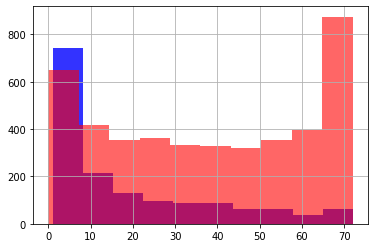

In [87]:
# Analisando o tempo de quem saiu e permaneceu na empresa
tempo = df.select('Churn','tenure').toPandas()
tempo[tempo.Churn == 'Yes']['tenure'].hist(alpha = 0.8, color = 'blue')
tempo[tempo.Churn == 'No']['tenure'].hist(alpha = 0.6, color = 'red')



### De acordo com a análise abaixo, tanto os clientes que saíram e ficaram tiveram/tem os mesmos produtos. Porém, um ponto de observação é que para aqueles que cancelaram, a Fibra optica é a mais presente. 

In [100]:
# Tipo de internet para clientes que saíram e permaneceram (revisar essa parte)
df.filter(df.InternetService != 'No').groupBy('Churn', 'InternetService').count().orderBy(df.Churn.desc()).show()

+-----+---------------+-----+
|Churn|InternetService|count|
+-----+---------------+-----+
|  Yes|    Fiber optic| 1091|
|  Yes|            DSL|  397|
|   No|            DSL| 1671|
|   No|    Fiber optic| 1536|
+-----+---------------+-----+



### Referente a total de cargas realizadas, aqui vemos que quem cancela geralmente não costuma fazer muita recarga... 

<AxesSubplot:>

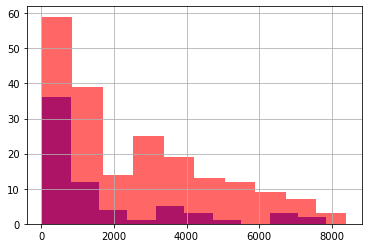

In [98]:
# Total de recargas para o cliente que permanceu e para quem cancelou
charge = df.select('Churn','TotalCharges').toPandas()
charge[charge.Churn == 'Yes']['TotalCharges'].hist(alpha = 0.8, color = 'blue')
charge[charge.Churn == 'No']['TotalCharges'].hist(alpha = 0.6, color = 'red')

### A maioria dos clientes que cancelam tem um contrato de Mês a mês. 

In [101]:
# Tipo de internet para clientes que saíram e permaneceram (revisar essa parte)
df.groupBy('Churn', 'Contract').count().orderBy(df.Churn.desc()).show()



+-----+--------------+-----+
|Churn|      Contract|count|
+-----+--------------+-----+
|  Yes|      One year|  148|
|  Yes|Month-to-month| 1398|
|  Yes|      Two year|   41|
|   No|      One year| 1128|
|   No|Month-to-month| 1871|
|   No|      Two year| 1400|
+-----+--------------+-----+



In [102]:
# Serviço de celular
df.groupBy('Churn', 'PhoneService').count().orderBy(df.Churn.desc()).show()

+-----+------------+-----+
|Churn|PhoneService|count|
+-----+------------+-----+
|  Yes|         Yes| 1438|
|  Yes|          No|  149|
|   No|          No|  441|
|   No|         Yes| 3958|
+-----+------------+-----+



In [103]:
# Multiplas linhas de telefone
df.groupBy('Churn', 'MultipleLines').count().orderBy(df.Churn.desc()).show()

+-----+----------------+-----+
|Churn|   MultipleLines|count|
+-----+----------------+-----+
|  Yes|No phone service|  149|
|  Yes|              No|  715|
|  Yes|             Yes|  723|
|   No|              No| 2133|
|   No|             Yes| 1825|
|   No|No phone service|  441|
+-----+----------------+-----+

